In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import sys
import time
import seaborn as sns
import os
import math
import pickle as pkl

#%%
# ML
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    f1_score,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_auc_score,
    classification_report,
    roc_curve,
    auc
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer

import torch
import torch.nn as nn
import torch.optim as optim

# # Anomaly detection models
# import pyod
# from pyod.models.ocsvm import OCSVM
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import (LocalOutlierFactor, NearestNeighbors)

### Todos: Try Different Scalers

In [3]:
# Data loading
df_head = pd.read_csv('../data/creditcard_2023_head.csv')

# Loading first setup
with open('../data/setup_1.pkl', 'rb') as f:
    setup1 = pkl.load(f)

X_train, _, X_test, y_test = setup1['X_train'], setup1['y_train'], setup1['X_test'], setup1['y_test']

X_train_without_id = X_train[:, 1:]  # Excluding 'id'
X_test_without_id = X_test[:, 1:]  # Excluding 'id'

# Todo: Try Different Scalers
scaler = MinMaxScaler().fit(X_train_without_id)  # Initialize the MinMaxScaler and fit to the training set
X_train_without_id_scaled = scaler.transform(X_train_without_id)  # the scaler is applied to the training set
X_test_without_id_scaled = scaler.transform(X_test_without_id)  # the scaler is applied to the test set

X_train_without_id_scaled_mini = X_test_without_id_scaled[:10000] # Prototyping with only 10000 instances.

In [6]:
# Assuming you have your X_train_scaled and X_test_scaled ready
# Set the number of neighbors
k = 5

# Initialize and fit the NearestNeighbors model
model = NearestNeighbors(n_neighbors=k)
model.fit(X_train_without_id_scaled_mini)

# Calculate the distance to the kth nearest neighbor for each point in the training set
distances, indices = model.kneighbors(X_train_without_id_scaled_mini)
kth_dist_train = distances[:, k-1]

# Calculate the distance to the kth nearest neighbor for each point in the test set
distances_test, indices_test = model.kneighbors(X_test_without_id_scaled)
kth_dist_test = distances_test[:, k-1]

# Set a threshold for anomaly detection
# This could be a fixed value or based on a percentile. Here we use the 95th percentile of the training distances.
threshold = np.percentile(kth_dist_train, 95)

# Detect anomalies in the training set
anomalies_train = kth_dist_train > threshold

# Detect anomalies in the test set
anomalies_test = kth_dist_test > threshold

# Now, anomalies_train and anomalies_test contain boolean arrays indicating anomalies in your datasets.

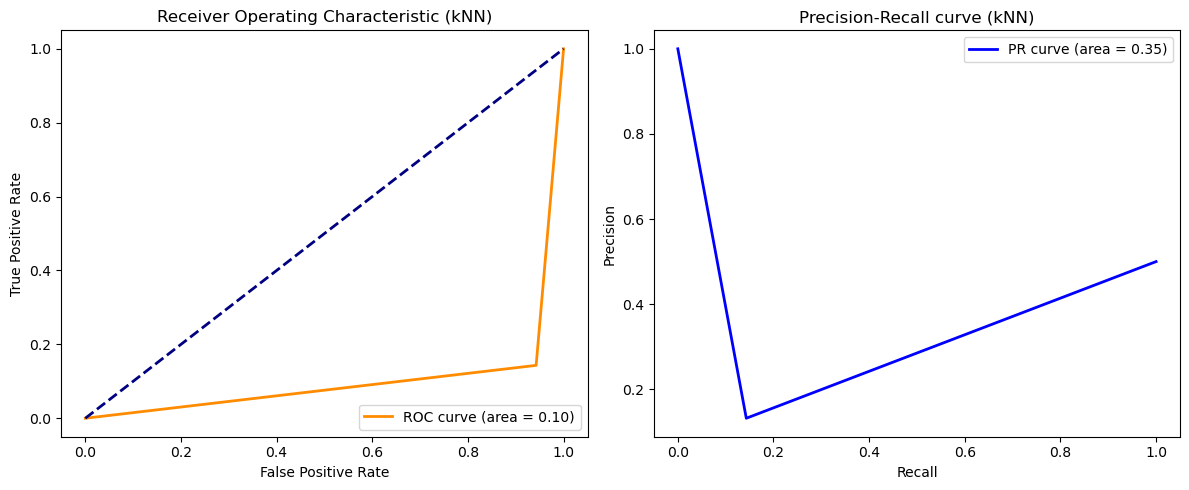

              precision    recall  f1-score   support

           0       0.06      0.06      0.06     28432
           1       0.13      0.14      0.14     28432

    accuracy                           0.10     56864
   macro avg       0.10      0.10      0.10     56864
weighted avg       0.10      0.10      0.10     56864



In [7]:
# Convert boolean anomaly flags to integer labels (0 for anomalies, 1 for normal)
# Convert predictions to match y_test labels (0 for anomalies, 1 for normal)
y_pred_test = (anomalies_test == False).astype(int)

# Calculate ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall Curve and AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_test)
pr_auc = auc(recall, precision)

# Generate a classification report
class_report = classification_report(y_test, y_pred_test)

# Plotting the ROC and Precision-Recall Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (kNN)')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve (kNN)')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

print(class_report)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: NearestNeighbors()